# Question 2
## Customer Segmentation using K-Means

Added by Tanishk Singh

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing
- Looking into order id discrepancy, as order ids are more in payments dataset than in items data set

In [2]:
# Reading all the datasets

customer_data = pd.read_csv("Dataset/raw/olist_customers_dataset.csv")
geolocation_data = pd.read_csv("Dataset/raw/olist_geolocation_dataset.csv")
items_data = pd.read_csv("Dataset/raw/olist_order_items_dataset.csv")
payments_data = pd.read_csv("Dataset/raw/olist_order_payments_dataset.csv")
reviews_data = pd.read_csv("Dataset/raw/olist_order_reviews_dataset.csv")
orders_data = pd.read_csv("Dataset/raw/olist_orders_dataset.csv")
products_data = pd.read_csv("Dataset/raw/olist_products_dataset.csv")
sellers_data = pd.read_csv("Dataset/raw/olist_sellers_dataset.csv")
product_category_translation_data = pd.read_csv("Dataset/raw/product_category_name_translation.csv")


In [46]:
# Get unique order IDs from each dataset
unique_order_ids_items = set(items_data['order_id'].unique())
unique_order_ids_payments = set(payments_data['order_id'].unique())
unique_order_ids_main = set(orders_data['order_id'].unique())

In [47]:
orders_in_payments_not_in_items = unique_order_ids_payments - unique_order_ids_items


In [48]:
missing_orders_details =orders_data[orders_data['order_id'].isin(orders_in_payments_not_in_items)]

In [49]:
missing_orders_details

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
266,8e24261a7e58791d10cb1bf9da94df5c,64a254d30eed42cd0e6c36dddb88adf0,unavailable,2017-11-16 15:09:28,2017-11-16 15:26:57,NaN,NaN,2017-12-05 00:00:00
586,c272bcd21c287498b4883c7512019702,9582c5bbecc65eb568e2c1d839b5cba1,unavailable,2018-01-31 11:31:37,2018-01-31 14:23:50,NaN,NaN,2018-02-16 00:00:00
687,37553832a3a89c9b2db59701c357ca67,7607cd563696c27ede287e515812d528,unavailable,2017-08-14 17:38:02,2017-08-17 00:15:18,NaN,NaN,2017-09-05 00:00:00
737,d57e15fb07fd180f06ab3926b39edcd2,470b93b3f1cde85550fc74cd3a476c78,unavailable,2018-01-08 19:39:03,2018-01-09 07:26:08,NaN,NaN,2018-02-06 00:00:00
1130,00b1cb0320190ca0daa2c88b35206009,3532ba38a3fd242259a514ac2b6ae6b6,canceled,2018-08-28 15:26:39,NaN,NaN,NaN,2018-09-12 00:00:00
...,...,...,...,...,...,...,...,...
99252,aaab15da689073f8f9aa978a390a69d1,df20748206e4b865b2f14a5eabbfcf34,unavailable,2018-01-16 14:27:59,2018-01-17 03:37:34,NaN,NaN,2018-02-06 00:00:00
99283,3a3cddda5a7c27851bd96c3313412840,0b0d6095c5555fe083844281f6b093bb,canceled,2018-08-31 16:13:44,NaN,NaN,NaN,2018-10-01 00:00:00
99347,a89abace0dcc01eeb267a9660b5ac126,2f0524a7b1b3845a1a57fcf3910c4333,canceled,2018-09-06 18:45:47,NaN,NaN,NaN,2018-09-27 00:00:00
99348,a69ba794cc7deb415c3e15a0a3877e69,726f0894b5becdf952ea537d5266e543,unavailable,2017-08-23 16:28:04,2017-08-28 15:44:47,NaN,NaN,2017-09-15 00:00:00


In [50]:
status_counts = missing_orders_details['order_status'].value_counts()
print("\nStatus distribution of these orders:")
print(status_counts)


Status distribution of these orders:
order_status
unavailable    603
canceled       164
created          5
invoiced         2
shipped          1
Name: count, dtype: int64


Much of the data above is missing or unavailable, possibly as these orders didn't successfully went through. 
For this project, we will only focus on order ids, which are common among all the datasets and whose values are available to us as that's what matters for our task of customer segmentation. Doing imputations will not help here due to nature of missing data. 

In [52]:
# Check if there are any orders in main orders that don't exist in the payments table
orders_in_main_not_in_payments = unique_order_ids_main - unique_order_ids_payments 
print(f"\nOrders in payments but not in main orders table: {orders_in_main_not_in_payments}")



Orders in payments but not in main orders table: {'bfbd0f9bdef84302105ad712db648a6c'}


In [53]:
order_details = orders_data[orders_data['order_id'] == 'bfbd0f9bdef84302105ad712db648a6c']


In [15]:
order_details

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
30710,bfbd0f9bdef84302105ad712db648a6c,86dc2ffce2dfff336de2f386a786e574,delivered,2016-09-15 12:16:38,2016-09-15 12:16:38,2016-11-07 17:11:53,2016-11-09 07:47:38,2016-10-04 00:00:00


This is a discrepancy in our dataset, one order value which was delivered doesn't have payments data, however the data on price and freight is present in item dataset thus we will be adding one more row to our payments dataset to accomodate this order id.

In [54]:
# calculating price for the order id

required_row = items_data[items_data['order_id'] == "bfbd0f9bdef84302105ad712db648a6c"]
price = required_row['price'] + required_row['freight_value']
print(price)


84389    47.82
84390    47.82
84391    47.82
dtype: float64


In [55]:
# adding row to payments data, here we have added some synthesised data based on mode values for a new order characteristics

new_payment = {
    'order_id': 'bfbd0f9bdef84302105ad712db648a6c',  # This is the order ID we found that exists in items but not in payments
    'payment_sequential': 1,  # Usually starts at 1 for a new order
    'payment_type': 'credit_card',  
    'payment_installments': 1, 
    'payment_value': 47.82   #using the price earlier calculated
}

# Convert the dictionary to a DataFrame with a single row
new_row_df = pd.DataFrame([new_payment])

# Append the new row to the existing DataFrame
updated_payments_df = pd.concat([payments_data, new_row_df], ignore_index=True)

In [56]:
len(updated_payments_df['order_id'].unique())

99441

Joining items and updated payments dataset on order id

In [57]:
items_payments_df = pd.merge(
    items_data,
    updated_payments_df,
    on='order_id',
    how='inner'
)

In [58]:
# adding customer id to our dataset by merging with main orders dataset

items_payments_df_2 = pd.merge(
    items_payments_df,
    orders_data,
    on='order_id',
    how='inner'
)

In [59]:
# creating the final dataset for question by adding customer details with a merge with customer dataset

customer_main = pd.merge(
    items_payments_df_2,
    customer_data,
    on='customer_id',
    how='inner'
)

In [22]:
customer_main

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,...,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,19-09-2017 09:45,58.90,13.29,1,credit_card,2,...,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,03-05-2017 11:05,239.90,19.93,1,credit_card,3,...,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,18-01-2018 14:48,199.00,17.87,1,credit_card,5,...,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,15-08-2018 10:10,12.99,12.79,1,credit_card,2,...,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,13-02-2017 13:57,199.90,18.14,1,credit_card,3,...,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117599,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,b8bc237ba3788b23da09c0f1f3a3288c,02-05-2018 04:11,299.99,43.41,1,boleto,1,...,delivered,2018-04-23 13:57:06,2018-04-25 04:11:01,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18 00:00:00,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA
117600,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,f3c38ab652836d21de61fb8314b69182,20-07-2018 04:31,350.00,36.53,1,boleto,1,...,delivered,2018-07-14 10:26:46,2018-07-17 04:31:48,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01 00:00:00,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR
117601,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,c3cfdc648177fdbbbb35635a37472c53,30-10-2017 17:14,99.90,16.95,1,credit_card,3,...,delivered,2017-10-23 17:07:56,2017-10-24 17:14:25,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10 00:00:00,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP
117602,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,2b3e4a2a3ea8e01938cabda2a3e5cc79,21-08-2017 00:04,55.99,8.72,1,credit_card,3,...,delivered,2017-08-14 23:02:59,2017-08-15 00:04:32,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25 00:00:00,eb803377c9315b564bdedad672039306,13289,vinhedo,SP


In [60]:
columns_to_remove = ['seller_id', 'shipping_limit_date','price','freight_value','payment_sequential','payment_type','payment_installments','order_status','order_approved_at',
                     'order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date']
customer_main_2 = customer_main.drop(columns=columns_to_remove)

In [61]:
customer_main_2

,order_id,order_item_id,product_id,payment_value,customer_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,72.19,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,259.83,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,216.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,25.78,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,218.04,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP
...,...,...,...,...,...,...,...,...,...,...
117599,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,343.40,b51593916b4b8e0d6f66f2ae24f2673d,2018-04-23 13:57:06,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA
117600,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,386.53,84c5d4fbaf120aae381fad077416eaa0,2018-07-14 10:26:46,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR
117601,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,116.85,29309aa813182aaddc9b259e31b870e6,2017-10-23 17:07:56,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP
117602,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,64.71,b5e6afd5a41800fdf401e0272ca74655,2017-08-14 23:02:59,eb803377c9315b564bdedad672039306,13289,vinhedo,SP


Dealing with missing values in product dataset as we would need to later merge product information with our customer dataset. We will be putting "unknown" where data is not available to us. This seems best option here as using predictive modeling is not a good choice, due to 73 distinct types in product category column. 

In [62]:
# Create an "unknown" category
products_data['product_category_name'] = products_data['product_category_name'].fillna('unknown_category')

# Verify no missing values remain
print(f"Missing values after filling: {products_data['product_category_name'].isna().sum()}")

Missing values after filling: 0


In [63]:
merged_products_df = pd.merge(
    products_data,
    product_category_translation_data,
    on='product_category_name',
    how='left'
)

In [64]:
merged_products_df['product_category_name_english'] = merged_products_df['product_category_name_english'].fillna('unknown_category')

In [65]:
customer_main_2

,order_id,order_item_id,product_id,payment_value,customer_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,72.19,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,259.83,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,216.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,25.78,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,218.04,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP
...,...,...,...,...,...,...,...,...,...,...
117599,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,343.40,b51593916b4b8e0d6f66f2ae24f2673d,2018-04-23 13:57:06,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA
117600,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,386.53,84c5d4fbaf120aae381fad077416eaa0,2018-07-14 10:26:46,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR
117601,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,116.85,29309aa813182aaddc9b259e31b870e6,2017-10-23 17:07:56,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP
117602,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,64.71,b5e6afd5a41800fdf401e0272ca74655,2017-08-14 23:02:59,eb803377c9315b564bdedad672039306,13289,vinhedo,SP


In [66]:
customer_final_df = pd.merge(
    customer_main_2,
    merged_products_df,
    on='product_id',
    how='inner'
)

In [67]:
customer_final_df

,order_id,order_item_id,product_id,payment_value,customer_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,72.19,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,259.83,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,pet_shop,56.0,239.0,2.0,30000.0,50.0,30.0,40.0,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,216.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,moveis_decoracao,59.0,695.0,2.0,3050.0,33.0,13.0,33.0,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,25.78,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,perfumaria,42.0,480.0,1.0,200.0,16.0,10.0,15.0,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,218.04,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,ferramentas_jardim,59.0,409.0,1.0,3750.0,35.0,40.0,30.0,garden_tools
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117599,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,343.40,b51593916b4b8e0d6f66f2ae24f2673d,2018-04-23 13:57:06,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,utilidades_domesticas,43.0,1002.0,3.0,10150.0,89.0,15.0,40.0,housewares
117600,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,386.53,84c5d4fbaf120aae381fad077416eaa0,2018-07-14 10:26:46,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,informatica_acessorios,31.0,232.0,1.0,8950.0,45.0,26.0,38.0,computers_accessories
117601,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,116.85,29309aa813182aaddc9b259e31b870e6,2017-10-23 17:07:56,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP,esporte_lazer,43.0,869.0,1.0,967.0,21.0,24.0,19.0,sports_leisure
117602,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,64.71,b5e6afd5a41800fdf401e0272ca74655,2017-08-14 23:02:59,eb803377c9315b564bdedad672039306,13289,vinhedo,SP,informatica_acessorios,56.0,1306.0,1.0,100.0,20.0,20.0,20.0,computers_accessories


In [68]:
columns_to_remove = ['product_description_lenght', 'product_photos_qty','product_weight_g','product_length_cm','product_height_cm','product_width_cm']
customer_final_df = customer_final_df.drop(columns=columns_to_remove)

In [69]:
columns_to_remove = ['product_name_lenght', 'product_category_name']

In [70]:
customer_final_df = customer_final_df.drop(columns=columns_to_remove)

In [71]:
customer_final_df

,order_id,order_item_id,product_id,payment_value,customer_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,72.19,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,259.83,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,216.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,25.78,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,218.04,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,garden_tools
...,...,...,...,...,...,...,...,...,...,...,...
117599,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,343.40,b51593916b4b8e0d6f66f2ae24f2673d,2018-04-23 13:57:06,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,housewares
117600,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,386.53,84c5d4fbaf120aae381fad077416eaa0,2018-07-14 10:26:46,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,computers_accessories
117601,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,116.85,29309aa813182aaddc9b259e31b870e6,2017-10-23 17:07:56,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP,sports_leisure
117602,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,64.71,b5e6afd5a41800fdf401e0272ca74655,2017-08-14 23:02:59,eb803377c9315b564bdedad672039306,13289,vinhedo,SP,computers_accessories


In [72]:
#our final merged dataset

customer_final_df.to_csv('customer_data_final.csv', index=False)


In [4]:
customer_data_final = pd.read_csv("customer_data_final.csv")

Before proceeding to further data pre-processing, let's have a look at our created dataset


In [75]:
# Load the data
customer_data_final = pd.read_csv("customer_data_final.csv")

# Display basic information
print(f"Dataset Shape: {customer_data_final.shape}")
print("\nFirst 5 rows:")
customer_data_final.head()


Dataset Shape: (117604, 11)

First 5 rows:


,order_id,order_item_id,product_id,payment_value,customer_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,72.19,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,259.83,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,216.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,25.78,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,218.04,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,garden_tools


In [76]:
print("\nData Types:")
print(customer_data_final.dtypes)


Data Types:
order_id                          object
order_item_id                      int64
product_id                        object
payment_value                    float64
customer_id                       object
order_purchase_timestamp          object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
product_category_name_english     object
dtype: object


In [77]:
# let's convert zip code to string type as it being an integer is not required
customer_data_final['customer_zip_code_prefix']= customer_data_final['customer_zip_code_prefix'].astype(str)
print(customer_data_final.dtypes)

print("\nSummary Statistics for numerical columns:")
print(customer_data_final.describe())

order_id                          object
order_item_id                      int64
product_id                        object
payment_value                    float64
customer_id                       object
order_purchase_timestamp          object
customer_unique_id                object
customer_zip_code_prefix          object
customer_city                     object
customer_state                    object
product_category_name_english     object
dtype: object

Summary Statistics for numerical columns:
       order_item_id  payment_value
count  117604.000000  117604.000000
mean        1.195920     172.683567
std         0.697721     267.589620
min         1.000000       0.000000
25%         1.000000      60.867500
50%         1.000000     108.210000
75%         1.000000     189.260000
max        21.000000   13664.080000


In [78]:
# lets check null values

print("\nMissing Values:")
print(customer_data_final.isnull().sum())



Missing Values:
order_id                         0
order_item_id                    0
product_id                       0
payment_value                    0
customer_id                      0
order_purchase_timestamp         0
customer_unique_id               0
customer_zip_code_prefix         0
customer_city                    0
customer_state                   0
product_category_name_english    0
dtype: int64


As our dataset is from Olist, one of the biggest ecommerce seller in Brazil, the data is quite clean.

In [79]:
print("\nUnique value count in the dataset columns:")
customer_data_final[['order_id','product_id','customer_id','customer_state']].apply(pd.Series.nunique)


Unique value count in the dataset columns:


order_id          98666
product_id        32951
customer_id       98666
customer_state       27
dtype: int64

There are total 1,17,604 rows in the dataset and only 98,666 unique order ids, meaning there are cases of multiple product ids asssociated with one order id, something to keep in mind, as this could be a potential segmentation group between customers, who tend to order more products or if there is are any product which are more ordered in combination with othe products.

In [80]:
print("\nUnique Product Categories:")
print(customer_data_final['product_category_name_english'].value_counts().head(10))


Unique Product Categories:
product_category_name_english
bed_bath_table           11823
health_beauty             9975
sports_leisure            8945
furniture_decor           8744
computers_accessories     8082
housewares                7355
watches_gifts             6201
telephony                 4721
garden_tools              4574
auto                      4379
Name: count, dtype: int64


In [81]:
print("\nStates Distribution:")
print(customer_data_final['customer_state'].value_counts())


States Distribution:
customer_state
SP    49569
RJ    15327
MG    13638
RS     6486
PR     5962
SC     4302
BA     4048
DF     2473
GO     2430
ES     2338
PE     1889
CE     1551
MT     1125
PA     1116
MA      844
MS      843
PB      639
PI      573
RN      569
AL      458
SE      397
TO      339
RO      286
AM      171
AC       95
AP       84
RR       52
Name: count, dtype: int64


In [82]:
customer_data_final.columns

Index(['order_id', 'order_item_id', 'product_id', 'payment_value',
       'customer_id', 'order_purchase_timestamp', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'product_category_name_english'],
      dtype='object')

# Feature Engineering 

Below code is our feature engineering, we are extracting and creating features specific to our customer segmentation from the final dataset we prepared

In [6]:
customer_data_final

,order_id,order_item_id,product_id,payment_value,customer_id,order_purchase_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,product_category_name_english
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,72.19,3ce436f183e68e07877b285a838db11a,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,cool_stuff
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,259.83,f6dd3ec061db4e3987629fe6b26e5cce,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,pet_shop
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,216.87,6489ae5e4333f3693df5ad4372dab6d3,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,furniture_decor
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,25.78,d4eb9395c8c0431ee92fce09860c5a06,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,perfumery
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,218.04,58dbd0b2d70206bf40e62cd34e84d795,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,garden_tools
...,...,...,...,...,...,...,...,...,...,...,...
117599,fffc94f6ce00a00581880bf54a75a037,1,4aa6014eceb682077f9dc4bffebc05b0,343.40,b51593916b4b8e0d6f66f2ae24f2673d,2018-04-23 13:57:06,0c9aeda10a71f369396d0c04dce13a64,65077,sao luis,MA,housewares
117600,fffcd46ef2263f404302a634eb57f7eb,1,32e07fd915822b0765e448c4dd74c828,386.53,84c5d4fbaf120aae381fad077416eaa0,2018-07-14 10:26:46,0da9fe112eae0c74d3ba1fe16de0988b,81690,curitiba,PR,computers_accessories
117601,fffce4705a9662cd70adb13d4a31832d,1,72a30483855e2eafc67aee5dc2560482,116.85,29309aa813182aaddc9b259e31b870e6,2017-10-23 17:07:56,cd79b407828f02fdbba457111c38e4c4,4039,sao paulo,SP,sports_leisure
117602,fffe18544ffabc95dfada21779c9644f,1,9c422a519119dcad7575db5af1ba540e,64.71,b5e6afd5a41800fdf401e0272ca74655,2017-08-14 23:02:59,eb803377c9315b564bdedad672039306,13289,vinhedo,SP,computers_accessories


For our feature engineering, we will be focusing on customer_unique_id as it's a unique order id associated with each customer.

In [7]:
# Calculate total spend per customer
customer_spend = customer_data_final.groupby('customer_unique_id')['payment_value'].sum().reset_index()
customer_spend.rename(columns={'payment_value': 'total_spend'}, inplace=True)
customer_spend

,customer_unique_id,total_spend
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,4134.84
95416,fffea47cd6d3cc0a88bd621562a9d061,84.58
95417,ffff371b4d645b6ecea244b27531430a,112.46
95418,ffff5962728ec6157033ef9805bacc48,133.69


In [8]:
# Calculate purchase frequency (number of orders)
customer_orders = customer_data_final.groupby('customer_unique_id')['order_id'].nunique().reset_index()
customer_orders.rename(columns={'order_id': 'order_count'}, inplace=True)

In [9]:
customer_orders

,customer_unique_id,order_count
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,1
95416,fffea47cd6d3cc0a88bd621562a9d061,1
95417,ffff371b4d645b6ecea244b27531430a,1
95418,ffff5962728ec6157033ef9805bacc48,1


In [10]:
# Calculate average order value
customer_avg_order = customer_data_final.groupby(['customer_unique_id', 'order_id'])['payment_value'].sum().reset_index()
customer_avg_order = customer_avg_order.groupby('customer_unique_id')['payment_value'].mean().reset_index()
customer_avg_order.rename(columns={'payment_value': 'avg_order_value'}, inplace=True)

In [11]:
customer_avg_order

,customer_unique_id,avg_order_value
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19
2,0000f46a3911fa3c0805444483337064,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,43.62
4,0004aac84e0df4da2b147fca70cf8255,196.89
...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,4134.84
95416,fffea47cd6d3cc0a88bd621562a9d061,84.58
95417,ffff371b4d645b6ecea244b27531430a,112.46
95418,ffff5962728ec6157033ef9805bacc48,133.69


In [21]:
# Getting most common product category per customer


customer_category = customer_data_final.groupby(['customer_unique_id', 'product_category_name_english']).size().reset_index(name='category_count')
customer_category = customer_category.sort_values(['customer_unique_id', 'category_count'], ascending=[True, False])
top_category = customer_category.drop_duplicates('customer_unique_id').reset_index(drop=True)

In the above, since we've already sorted the data by category count (in descending order), the first occurrence of each customer ID corresponds to their most purchased category. Thus, we dropped the duplicates to keep just the top category in our dataset.

In [22]:
top_category

,customer_unique_id,product_category_name_english,category_count
0,0000366f3b9a7992bf8c76cfdf3221e2,bed_bath_table,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,health_beauty,1
2,0000f46a3911fa3c0805444483337064,stationery,1
3,0000f6ccb0745a6a4b88665a16c9f078,telephony,1
4,0004aac84e0df4da2b147fca70cf8255,telephony,1
...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,health_beauty,2
95416,fffea47cd6d3cc0a88bd621562a9d061,baby,1
95417,ffff371b4d645b6ecea244b27531430a,auto,1
95418,ffff5962728ec6157033ef9805bacc48,watches_gifts,1


In [24]:
# Calculate product category diversity (number of unique categories purchased)
category_diversity = customer_data_final.groupby('customer_unique_id')['product_category_name_english'].nunique().reset_index()
category_diversity.rename(columns={'product_category_name_english': 'category_diversity'}, inplace=True)

In [105]:
category_diversity

,customer_unique_id,category_diversity
0,0000366f3b9a7992bf8c76cfdf3221e2,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1
2,0000f46a3911fa3c0805444483337064,1
3,0000f6ccb0745a6a4b88665a16c9f078,1
4,0004aac84e0df4da2b147fca70cf8255,1
...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,1
95416,fffea47cd6d3cc0a88bd621562a9d061,1
95417,ffff371b4d645b6ecea244b27531430a,1
95418,ffff5962728ec6157033ef9805bacc48,1


In [25]:
# Getting geographic information (state)
customer_geography = customer_data_final[['customer_unique_id', 'customer_state', 'customer_city', 'customer_zip_code_prefix']].drop_duplicates('customer_unique_id').reset_index(drop=True)



In [26]:
customer_geography

,customer_unique_id,customer_state,customer_city,customer_zip_code_prefix
0,871766c5855e863f6eccc05f988b23cb,RJ,campos dos goytacazes,28013
1,eb28e67c4c0b83846050ddfb8a35d051,SP,santa fe do sul,15775
2,3818d81c6709e39d06b2738a8d3a2474,MG,para de minas,35661
3,af861d436cfc08b2c2ddefd0ba074622,SP,atibaia,12952
4,64b576fb70d441e8f1b2d7d446e483c5,SP,varzea paulista,13226
...,...,...,...,...
95415,0c9aeda10a71f369396d0c04dce13a64,MA,sao luis,65077
95416,0da9fe112eae0c74d3ba1fe16de0988b,PR,curitiba,81690
95417,cd79b407828f02fdbba457111c38e4c4,SP,sao paulo,4039
95418,eb803377c9315b564bdedad672039306,SP,vinhedo,13289


In [ ]:
# Convert timestamp to datetime
customer_data_final['order_purchase_timestamp'] = pd.to_datetime(customer_data_final['order_purchase_timestamp'])

# Setting reference date (last date in the dataset plus 1 day)
last_date = customer_data_final['order_purchase_timestamp'].max() + pd.Timedelta(days=1) 
# a usual practice in RFM analysis, making sure the recent date is atleast 1 day
print(f"Reference date for recency calculation: {last_date}")

# Calculating recency (days since last purchase)
customer_recency = customer_data_final.groupby('customer_unique_id')['order_purchase_timestamp'].max().reset_index()
customer_recency['recency_days'] = (last_date - customer_recency['order_purchase_timestamp']).dt.days
customer_recency.drop('order_purchase_timestamp', axis=1, inplace=True)

Reference date for recency calculation: 2018-09-04 09:06:57


In [37]:
customer_recency

,customer_unique_id,recency_days
0,0000366f3b9a7992bf8c76cfdf3221e2,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,119
2,0000f46a3911fa3c0805444483337064,542
3,0000f6ccb0745a6a4b88665a16c9f078,326
4,0004aac84e0df4da2b147fca70cf8255,293
...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,452
95416,fffea47cd6d3cc0a88bd621562a9d061,267
95417,ffff371b4d645b6ecea244b27531430a,573
95418,ffff5962728ec6157033ef9805bacc48,124


In [ ]:
# Merging all features into a single customer-level dataset
customer_features = customer_spend.merge(customer_orders, on='customer_unique_id')
customer_features = customer_features.merge(customer_avg_order, on='customer_unique_id')
customer_features = customer_features.merge(top_category[['customer_unique_id', 'product_category_name_english', 'category_count']], 
                                            on='customer_unique_id')
customer_features = customer_features.merge(category_diversity, on='customer_unique_id')
customer_features = customer_features.merge(customer_geography, on='customer_unique_id')
customer_features = customer_features.merge(customer_recency, on='customer_unique_id')

In [39]:
customer_features

,customer_unique_id,total_spend,order_count,avg_order_value,product_category_name_english,category_count,category_diversity,customer_state,customer_city,customer_zip_code_prefix,recency_days
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,141.90,bed_bath_table,1,1,SP,cajamar,7787,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,27.19,health_beauty,1,1,SP,osasco,6053,119
2,0000f46a3911fa3c0805444483337064,86.22,1,86.22,stationery,1,1,SC,sao jose,88115,542
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1,43.62,telephony,1,1,PA,belem,66812,326
4,0004aac84e0df4da2b147fca70cf8255,196.89,1,196.89,telephony,1,1,SP,sorocaba,18040,293
...,...,...,...,...,...,...,...,...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,4134.84,1,4134.84,health_beauty,2,1,PE,sanharo,55250,452
95416,fffea47cd6d3cc0a88bd621562a9d061,84.58,1,84.58,baby,1,1,BA,feira de santana,44054,267
95417,ffff371b4d645b6ecea244b27531430a,112.46,1,112.46,auto,1,1,MT,sinop,78552,573
95418,ffff5962728ec6157033ef9805bacc48,133.69,1,133.69,watches_gifts,1,1,ES,bom jesus do norte,29460,124


In [40]:
# Rename columns for clarity
customer_features.rename(columns={'product_category_name_english': 'top_category'}, inplace=True)

In [43]:
print("\nCustomer-level Features Dataset:")
print(f"Shape: {customer_features.shape}")


# Basic statistics of features
print("\nSummary Statistics of Customer Features:")
print(customer_features[['total_spend', 'order_count', 'avg_order_value', 'category_diversity','recency_days']].describe())



Customer-level Features Dataset:
Shape: (95420, 11)

Summary Statistics of Customer Features:
         total_spend   order_count  avg_order_value  category_diversity  \
count   95420.000000  95420.000000     95420.000000        95420.000000   
mean      212.830415      1.034018       205.461388            1.026148   
std       641.759758      0.211234       619.344503            0.172149   
min         9.590000      1.000000         9.590000            1.000000   
25%        63.910000      1.000000        63.130000            1.000000   
50%       113.150000      1.000000       110.635000            1.000000   
75%       202.542500      1.000000       196.010000            1.000000   
max    109312.640000     16.000000    109312.640000            5.000000   

       recency_days  
count  95420.000000  
mean     243.600377  
std      153.160320  
min        1.000000  
25%      119.000000  
50%      224.000000  
75%      353.000000  
max      729.000000  


Feature Engineering is complete, now let's analyse our newly created features

# Exploratory Data Analysis

In [49]:
customer_features['total_spend'].max()

109312.64

Text(0.5, 1.0, 'Box Plot of Total Spend')

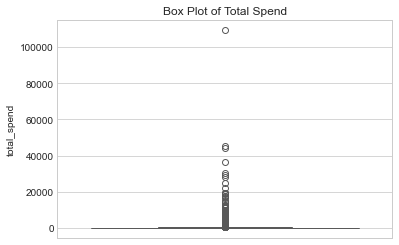

In [50]:
# let's detect outliers using box plot

sns.boxplot(y=customer_features['total_spend'])
plt.title(f'Box Plot of Total Spend')

Text(0.5, 0, 'Total Spend')

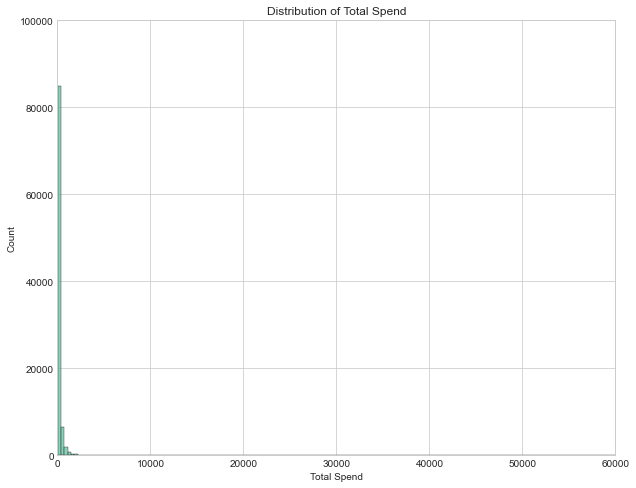

In [59]:
plt.figure(figsize=(10,8))
plt.xlim(0, 60000)  # Set x-axis limits 
plt.ylim(0, 100000)    # Set y-axis limits 
sns.histplot(customer_features['total_spend'],bins=300)
plt.title('Distribution of Total Spend')
plt.xlabel('Total Spend')

In [70]:
customer_features

,customer_unique_id,total_spend,order_count,avg_order_value,top_category,category_count,category_diversity,customer_state,customer_city,customer_zip_code_prefix,recency_days
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,141.90,bed_bath_table,1,1,SP,cajamar,7787,116
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,27.19,health_beauty,1,1,SP,osasco,6053,119
2,0000f46a3911fa3c0805444483337064,86.22,1,86.22,stationery,1,1,SC,sao jose,88115,542
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1,43.62,telephony,1,1,PA,belem,66812,326
4,0004aac84e0df4da2b147fca70cf8255,196.89,1,196.89,telephony,1,1,SP,sorocaba,18040,293
...,...,...,...,...,...,...,...,...,...,...,...
95415,fffcf5a5ff07b0908bd4e2dbc735a684,4134.84,1,4134.84,health_beauty,2,1,PE,sanharo,55250,452
95416,fffea47cd6d3cc0a88bd621562a9d061,84.58,1,84.58,baby,1,1,BA,feira de santana,44054,267
95417,ffff371b4d645b6ecea244b27531430a,112.46,1,112.46,auto,1,1,MT,sinop,78552,573
95418,ffff5962728ec6157033ef9805bacc48,133.69,1,133.69,watches_gifts,1,1,ES,bom jesus do norte,29460,124


Text(0.5, 0, 'Order Count')

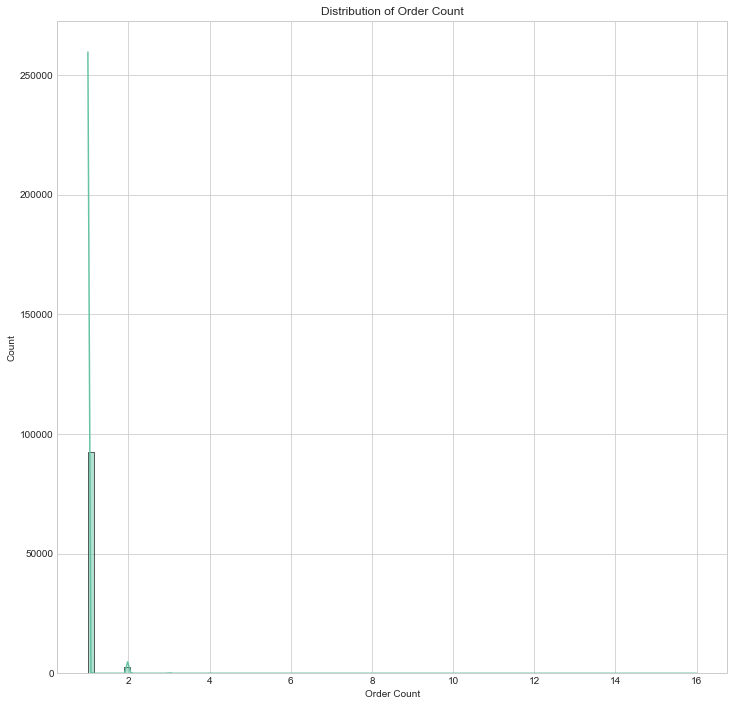

In [91]:
plt.figure(figsize=(12,12))
sns.histplot(customer_features['order_count'],kde=True,bins=100)
plt.title('Distribution of Order Count')
plt.xlabel('Order Count')

Text(0.5, 0, 'Number of Unique Categories')

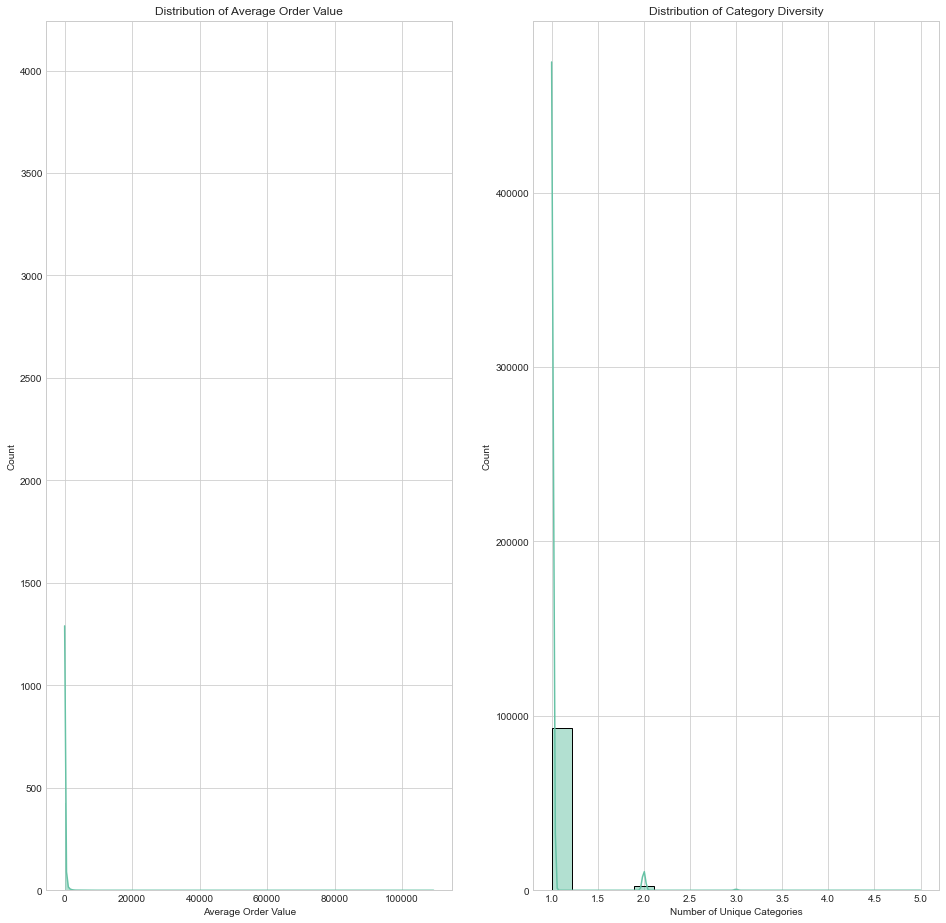

In [96]:
plt.figure(figsize=(16,16))

plt.subplot(1,2,1)
sns.histplot(customer_features['avg_order_value'], kde=True)
plt.title('Distribution of Average Order Value')
plt.xlabel('Average Order Value')

plt.subplot(1,2,2)
sns.histplot(customer_features['category_diversity'], kde=True)
plt.title('Distribution of Category Diversity')
plt.xlabel('Number of Unique Categories')

In the above graph, we can see the effect of outliers heavily skews our data, thus we would need to apply scaling to various features of the dataset before processding to clustering to find customer segments

# Some more Data Preprocessing: 

- In this step, we're handling outliers and scaling the data:

- Outlier Handling: We're using the IQR method to cap extreme values. This is important because K-means is sensitive to outliers. In e-commerce data, you'll often see customers with extremely high purchase amounts that can distort your clusters if not addressed.

- Feature Scaling: We're using StandardScaler to give all features equal importance in the clustering. Without scaling, features with larger values (like total_spend) would dominate the clustering process.

In [106]:
numerical_features = ['total_spend', 'recency_days', 'avg_order_value']
clustering_data = customer_features[numerical_features].copy()


# Check for and handle outliers using IQR
def handle_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_clean[col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])
        df_clean[col] = np.where(df_clean[col] < lower_bound, lower_bound, df_clean[col])
    return df_clean

# Handle outliers
clustering_data = handle_outliers(clustering_data, numerical_features)

# Add binary feature for repeat customers (order_count > 1)
clustering_data['is_repeat_customer'] = (customer_features['order_count'] > 1).astype(int)
customer_features['is_repeat_customer'] = (customer_features['order_count'] > 1).astype(int)


# Add binary feature for category explorers (category_diversity > 1)
clustering_data['is_category_explorer'] = (customer_features['category_diversity'] > 1).astype(int)
customer_features['is_category_explorer'] = (customer_features['category_diversity'] > 1).astype(int)


# Scale only the continuous features
continuous_features = ['total_spend', 'recency_days', 'avg_order_value']
scaler = StandardScaler()
clustering_data[continuous_features] = scaler.fit_transform(clustering_data[continuous_features])

print("\nModified Features for Clustering:")
print(clustering_data.head())


Modified Features for Clustering:
   total_spend  recency_days  avg_order_value  is_repeat_customer  \
0    -0.094589     -0.833128        -0.058469                   0   
1    -1.072238     -0.813540        -1.079565                   0   
2    -0.569138      1.948324        -0.554107                   0   
3    -0.932209      0.538010        -0.933312                   0   
4     0.374079      0.322546         0.431026                   0   

   is_category_explorer  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  


In [103]:
clustering_data

,total_spend,recency_days,avg_order_value,is_repeat_customer,is_category_explorer
0,-0.094589,-0.833128,-0.058469,0,0
1,-1.072238,-0.813540,-1.079565,0,0
2,-0.569138,1.948324,-0.554107,0,0
3,-0.932209,0.538010,-0.933312,0,0
4,0.374079,0.322546,0.431026,0,0
...,...,...,...,...,...
95415,2.194558,1.360693,2.197447,0,0
95416,-0.583115,0.152786,-0.568705,0,0
95417,-0.345500,2.150730,-0.320531,0,0
95418,-0.164561,-0.780894,-0.131551,0,0


Two new features have been added and order count as well as order diversity columns have been removed. This is because those columns had very low variations and extreme outliers, thus to capture that information we created a binary features.

# Applying K-Means

In [110]:
n_clusters = 5  #usually five clusters are optimum to get valuable segemntation patterns

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(clustering_data)
cluster_labels

array([1, 3, 0, ..., 0, 1, 0])

In [ ]:
# Adding cluster labels to the customer features
customer_features['cluster'] = cluster_labels

print("\nCustomer Features with Clusters:")
customer_features.head()



Customer Features with Clusters:


,customer_unique_id,total_spend,order_count,avg_order_value,top_category,category_count,category_diversity,customer_state,customer_city,customer_zip_code_prefix,recency_days,cluster,is_repeat_customer,is_category_explorer
0,0000366f3b9a7992bf8c76cfdf3221e2,141.90,1,141.90,bed_bath_table,1,1,SP,cajamar,7787,116,1,0,0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,27.19,1,27.19,health_beauty,1,1,SP,osasco,6053,119,3,0,0
2,0000f46a3911fa3c0805444483337064,86.22,1,86.22,stationery,1,1,SC,sao jose,88115,542,0,0,0
3,0000f6ccb0745a6a4b88665a16c9f078,43.62,1,43.62,telephony,1,1,PA,belem,66812,326,0,0,0
4,0004aac84e0df4da2b147fca70cf8255,196.89,1,196.89,telephony,1,1,SP,sorocaba,18040,293,1,0,0


In [ ]:
# Detailed cluster statistics
cluster_stats = customer_features.groupby('cluster').agg({
    'total_spend': ['mean', 'median'],
    'order_count': ['mean', 'median'],
    'recency_days': ['mean', 'median'],
    'avg_order_value': ['mean', 'median'],
    'category_diversity': ['mean', 'median'],
    'is_repeat_customer': ['mean'],
    'is_category_explorer': ['mean'],
    'customer_unique_id': 'count'
}).reset_index()

print("\nCluster Statistics:")
cluster_stats


Cluster Statistics:


cluster total_spend         order_count        recency_days         \
                 mean  median        mean median         mean median   
0       0   92.249016   84.05    1.022024    1.0   423.305666  414.0   
1       1  186.688238  178.03    1.051457    1.0   165.943608  167.0   
2       2  590.331728  350.19    1.056507    1.0   422.995026  413.5   
3       3   70.075956   66.93    1.016617    1.0   149.047964  150.0   
4       4  776.990169  497.66    1.073019    1.0   152.667001  151.0   

  avg_order_value          category_diversity        is_repeat_customer  \
             mean   median               mean median               mean   
0       90.634508   82.600           1.011135    1.0           0.020709   
1      180.407142  173.590           1.036087    1.0           0.045854   
2      570.613982  336.605           1.051810    1.0           0.050152   
3       69.120875   66.130           1.009906    1.0           0.016007   
4      740.271893  476.095           1.080843    1.0           0.060481   

  is_category_explorer customer_unique_id  
                  mean              count  
0             0.010766              24337  
1             0.033928              19453  
2             0.049047               7238  
3             0.009703              34422  
4             0.071815               9970

# Visualising Clusters

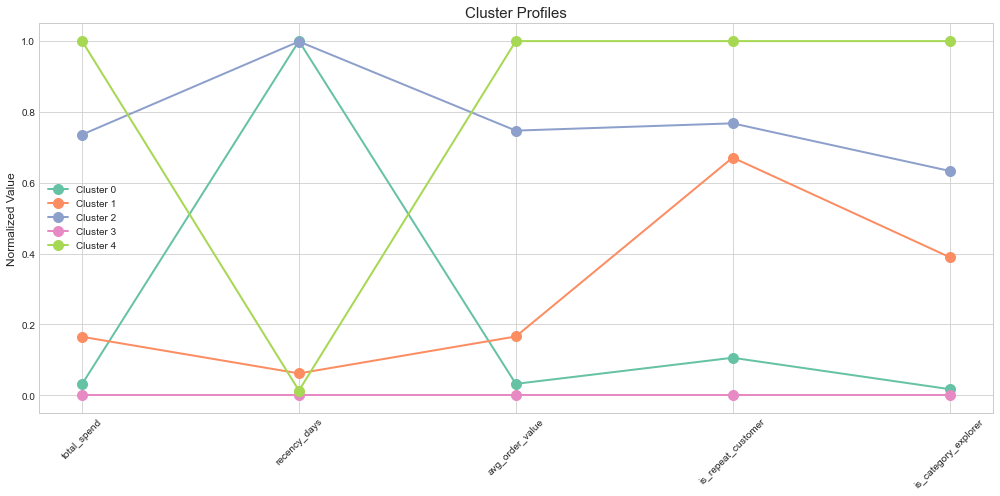

AttributeError: Rectangle.set() got an unexpected keyword argument 'colors'

<Figure size 1008x504 with 0 Axes>

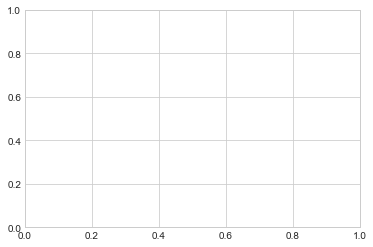

In [ ]:
# Function to plot cluster profiles
def plot_cluster_profiles(df, cluster_col, feature_cols):
    n_clusters = df[cluster_col].nunique()
    cluster_means = df.groupby(cluster_col)[feature_cols].mean()
    
    # Normalize for comparison
    cluster_means_scaled = (cluster_means - cluster_means.min()) / (cluster_means.max() - cluster_means.min())
    
    # Plot
    plt.figure(figsize=(14, 7))
    for i in range(n_clusters):
        plt.plot(feature_cols, cluster_means_scaled.iloc[i], marker='o', label=f'Cluster {i}', linewidth=2, markersize=10)
    
    plt.title('Cluster Profiles', fontsize=15)
    plt.ylabel('Normalized Value', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Cluster profiles for our selected features
selected_features = ['total_spend', 'recency_days', 'avg_order_value', 'is_repeat_customer', 'is_category_explorer']
plot_cluster_profiles(customer_features, 'cluster', selected_features)

# Geographic distribution of clusters
plt.figure(figsize=(14, 7))
cluster_state = customer_features.groupby(['customer_state', 'cluster']).size().unstack().fillna(0)
cluster_state_pct = cluster_state.div(cluster_state.sum(axis=1), axis=0)

colors = sns.color_palette("viridis", len(cluster_state_pct.columns))

# Top 10 states
top_states = customer_features['customer_state'].value_counts().head(10).index
cluster_state_pct.loc[top_states].plot(kind='bar', stacked=True,color = colors)
plt.title('Cluster Distribution by State (Top 10 States)', fontsize=15)
plt.xlabel('State', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(
    title='Cluster',
    bbox_to_anchor=(1.05, 1),  # Position to the right of the plot
    loc='upper left',
    borderaxespad=0
)
plt.tight_layout()
plt.show()

# Product category distribution by cluster
category_cluster = pd.crosstab(customer_features['top_category'], customer_features['cluster'])
category_cluster_pct = category_cluster.div(category_cluster.sum(axis=0), axis=1)

# Top 10 categories
top_categories = customer_features['top_category'].value_counts().head(10).index
plt.figure(figsize=(14, 7))
category_cluster_pct.loc[top_categories].plot(kind='bar')
plt.title('Top Product Categories by Cluster', fontsize=15)
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Proportion within Cluster', fontsize=12)
plt.legend(title='Cluster')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

# Interpreting the results

In [118]:
# Detailed characteristics of each cluster
for i in range(n_clusters):
    cluster_i = customer_features[customer_features['cluster'] == i]
    print(f"\n{'-'*20} CLUSTER {i} {'-'*20}")
    print(f"Number of customers: {len(cluster_i)} ({len(cluster_i) / len(customer_features):.2%} of total)")
    
    # RFM metrics
    print(f"Average total spend: ${cluster_i['total_spend'].mean():.2f}")
    print(f"Average order count: {cluster_i['order_count'].mean():.2f}")
    print(f"Average recency (days): {cluster_i['recency_days'].mean():.2f}")
    print(f"Average order value: ${cluster_i['avg_order_value'].mean():.2f}")
    
    # Category behavior
    print(f"Average category diversity: {cluster_i['category_diversity'].mean():.2f}")
    print(f"Repeat customers: {(cluster_i['is_repeat_customer'].mean() * 100):.1f}%")
    print(f"Category explorers: {(cluster_i['is_category_explorer'].mean() * 100):.1f}%")
    
    print("\nTop 5 states:")
    print(cluster_i['customer_state'].value_counts().head(5))
    
    print("\nTop 5 product categories:")
    print(cluster_i['top_category'].value_counts().head(5))



-------------------- CLUSTER 0 --------------------
Number of customers: 24337 (25.51% of total)
Average total spend: $92.25
Average order count: 1.02
Average recency (days): 423.31
Average order value: $90.63
Average category diversity: 1.01
Repeat customers: 2.1%
Category explorers: 1.1%

Top 5 states:
customer_state
SP    9801
RJ    3304
MG    2903
RS    1479
PR    1257
Name: count, dtype: int64

Top 5 product categories:
top_category
bed_bath_table     2515
sports_leisure     2086
health_beauty      1902
furniture_decor    1729
housewares         1556
Name: count, dtype: int64

-------------------- CLUSTER 1 --------------------
Number of customers: 19453 (20.39% of total)
Average total spend: $186.69
Average order count: 1.05
Average recency (days): 165.94
Average order value: $180.41
Average category diversity: 1.04
Repeat customers: 4.6%
Category explorers: 3.4%

Top 5 states:
customer_state
SP    7544
RJ    2709
MG    2357
RS    1014
PR     949
Name: count, dtype: int64

Top 5

Let's analyze each customer segment:

**Cluster 0: "High Recency Mid-Value Customers" :**

Moderate average spend ($92.25), very low repeat purchase rate (2.1%), and highest recency (423 days)
Behavior: These customers made a single moderate-value purchase, but haven't returned in over a year
Geographic Insight: Heavily concentrated in SP state
Category Preference: Home goods (bed & bath, furniture) and personal items (sports, health & beauty)

*Marketing Recommendations:*

Implement a reactivation campaign with significant incentives (20-30% discount)
Consider a "We miss you" campaign with time-limited offers
Test different incentives across segments of this cluster to identify what drives reactivation

**Cluster 1: "Recent Mid-Value Customers"**

Higher average spend ($186.69), recent purchases (165 days), slightly higher repeat purchase rate (4.6%)
These customers made relatively recent purchases with mid-range values
Gift-oriented items (watches & gifts) feature prominently

*Marketing Recommendations:*
Target around gift-giving occasions (holidays, etc.)

**Cluster 2: "High Recency High-Value Customers":**

High average spend ($590.33), very low repeat rate (5%), high recency (423 days)
These customers made significant high-value purchases but haven't returned in over a year
Home goods dominate (bed & bath, furniture)

*Marketing Recommendations:*

Personalized outreach with exclusive offers
Focus on home renovation or refresh messaging
Offer free shipping or installation services as incentives

**Cluster 3: "Recent Low-Value Customers" (36.07%)**

Lowest average spend ($70.08), recent purchases (149 days), lowest repeat rate (1.6%)
These customers made a single low-value purchase relatively recently
Largest cluster with widest geographic distribution

*Marketing Recommendations*:
Create bundle offers to encourage larger purchases
Implement "frequently bought together" suggestions

**Cluster 4: "Recent High-Value Explorers":**

Highest average spend ($776.99), recent purchases (152 days), highest repeat rate (6%) and highest category diversity (7.2% are category explorers)
These are the most valuable and engaged customers who spend significantly and explore different categories
Higher concentration in SP state
Most diverse preferences, led by health & beauty

*Marketing Recommendations:*

Implement a premium loyalty program for these high-value customers
Provide early access to new products and exclusive collections
Develop personalized communications based on browsing and purchase history
